### Simple 1D example of `Hilbert DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    plot_ddpm_1d_result,
    get_hbm_M,
)
from dataset import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[1.12.0+cu113].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# for k_idx,key in enumerate(dc.keys()): print ("[%2d] key:[%s]"%(k_idx,key))
# plot_ddpm_constants(dc)

In [3]:
# Instantiate U-net
device = 'cuda:0' # mps, cpu
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 1,
    n_base_channels      = 128,
    n_emb_dim            = 128,
    n_cond_dim           = 1,
    n_enc_blocks         = 5, # number of encoder blocks
    n_dec_blocks         = 5, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False,
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,2,4,8),
    updown_rates         = (1,1,2,2,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x L] => output:[B x C x L]
print ("Ready.")

Ready.


### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

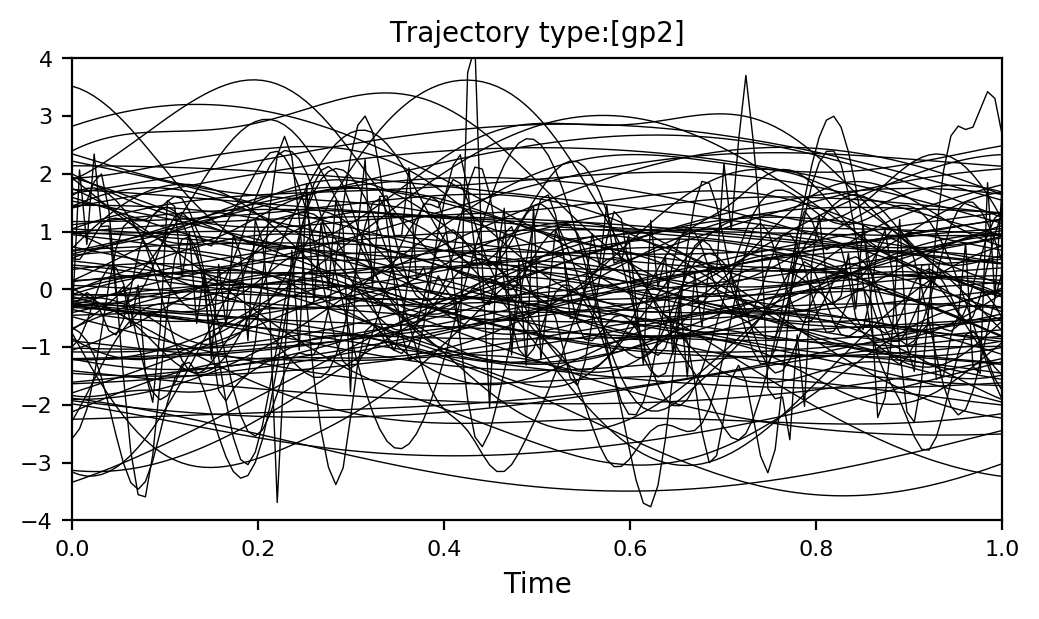

x_0:[100x1x128]


In [5]:
times,x_0, _ = get_1d_training_data(
    traj_type = 'gp2', # gp / step / step2
    n_traj    = 100,
    L         = 128,
    device    = device,
    seed      = 0,
    plot_data = True,
    figsize   = (6,3),
    ls        = '-',
    lc        = 'k',
    lw        = 1/2,
    verbose   = True
    )

### Multi-resolution Hilbert Spaces

In [7]:
M_list = []
M_list.append(
    th.from_numpy(np.eye(len(times))).to(th.float32).to(device)
)
for hyp_len in [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    M = get_hbm_M(times,hyp_gain=1.0,hyp_len=hyp_len,device=device) # [L x L]
    M_list.append(M)
# M = None
print ("Hilbert Brownian motion ready.")

Hilbert Brownian motion ready.


### Train

In [33]:
# Configuration
max_iter    = int(5e5)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    cond_idx = np.random.randint(0,7)
    cond_batch = th.Tensor([0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]).to(device).repeat(128,1)[idx,cond_idx].reshape(128,1)
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc,M_list[cond_idx]) # [B x C x L]
    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch,cond_batch) # [B x C x L]
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    # if (it%eval_every) == 0 or it == (max_iter-1):
    #     n_sample = 20
    #     step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    #     M_eval = None
    #     x_t_list = eval_ddpm_1d(
    #         model,dc,n_sample,x_0,step_list_to_append,device,M_eval)
    #     plot_ddpm_1d_result(
    #         times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
    #         plot_ancestral_sampling=True,plot_one_sample=False,
    #         lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
    #         ls_gt='-',ls_sample='--',ylim=(-4,+4),figsize=(5,3))

print ("Done.")

it:[      0][0.0]% loss:[1.0848]
it:[   1000][0.2]% loss:[0.3420]
it:[   2000][0.4]% loss:[0.3188]
it:[   3000][0.6]% loss:[0.6630]
it:[   4000][0.8]% loss:[0.2428]
it:[   5000][1.0]% loss:[0.5491]
it:[   6000][1.2]% loss:[0.2139]
it:[   7000][1.4]% loss:[0.5897]
it:[   8000][1.6]% loss:[0.4388]
it:[   9000][1.8]% loss:[0.4775]
it:[  10000][2.0]% loss:[0.4825]
it:[  11000][2.2]% loss:[0.2091]
it:[  12000][2.4]% loss:[0.2214]
it:[  13000][2.6]% loss:[0.4574]
it:[  14000][2.8]% loss:[0.4541]
it:[  15000][3.0]% loss:[0.4297]
it:[  16000][3.2]% loss:[0.4463]
it:[  17000][3.4]% loss:[0.1697]
it:[  18000][3.6]% loss:[0.4342]
it:[  19000][3.8]% loss:[0.4349]
it:[  20000][4.0]% loss:[0.5222]
it:[  21000][4.2]% loss:[0.4642]
it:[  22000][4.4]% loss:[0.4545]
it:[  23000][4.6]% loss:[0.1555]
it:[  24000][4.8]% loss:[0.1687]
it:[  25000][5.0]% loss:[0.4347]
it:[  26000][5.2]% loss:[0.3530]
it:[  27000][5.4]% loss:[0.4687]
it:[  28000][5.6]% loss:[0.4198]
it:[  29000][5.8]% loss:[0.3141]
it:[  3000

### Evaluate

hyp_len:[1.000e-03]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


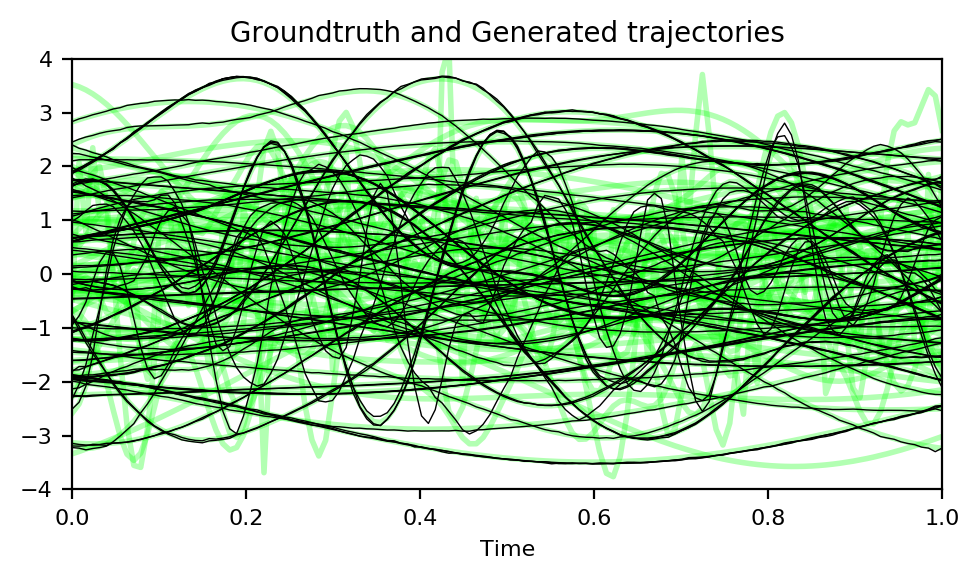

hyp_len:[1.000e-01]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


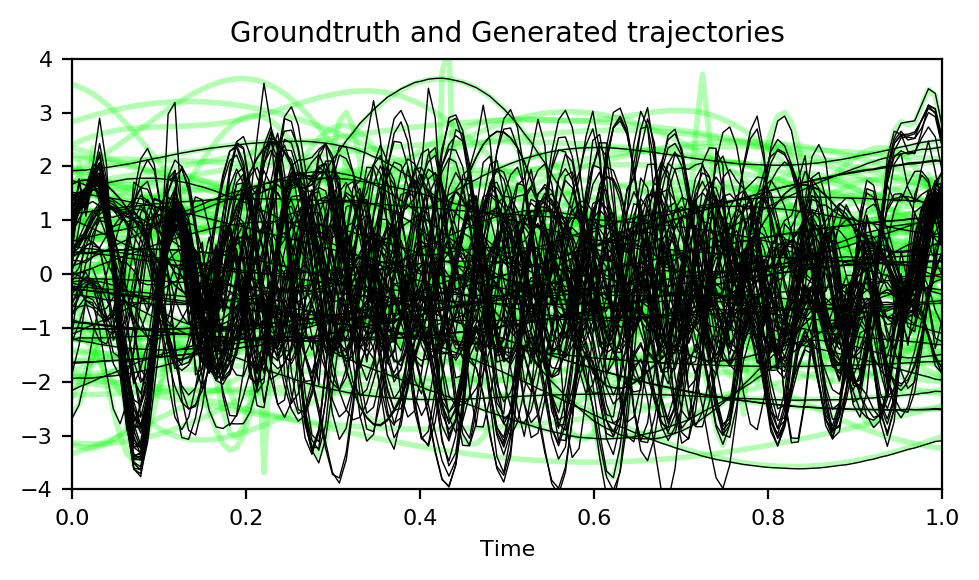

hyp_len:[2.000e-01]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


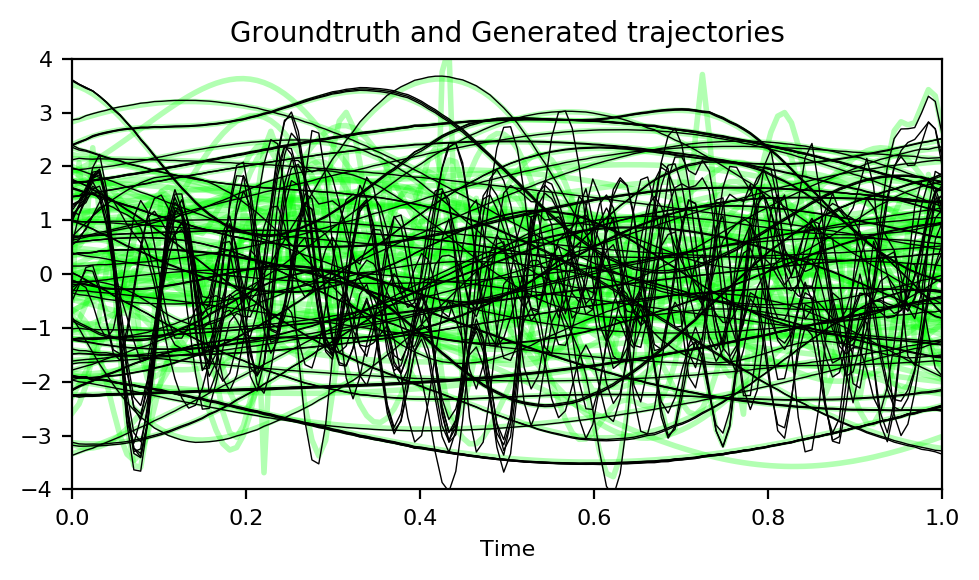

hyp_len:[4.000e-01]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


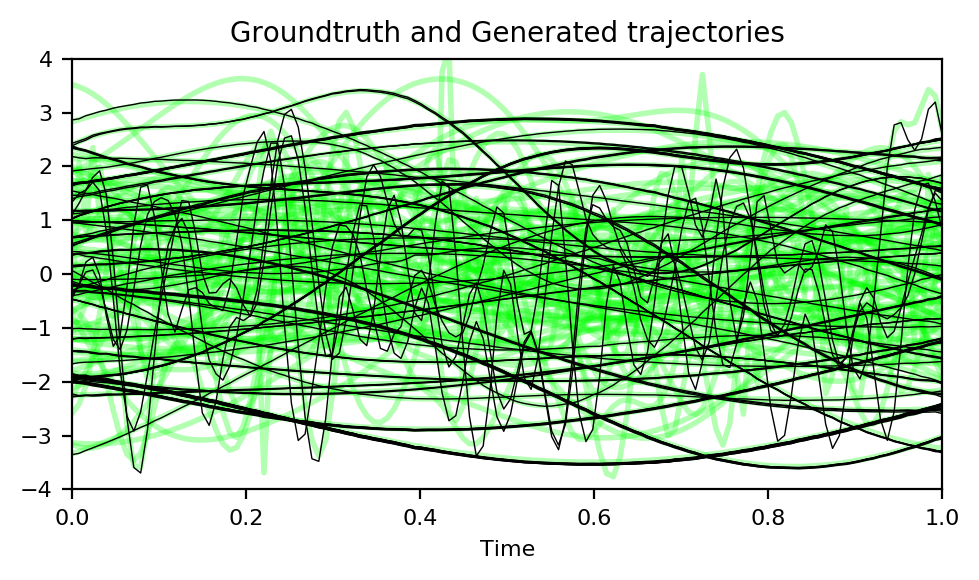

hyp_len:[6.000e-01]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


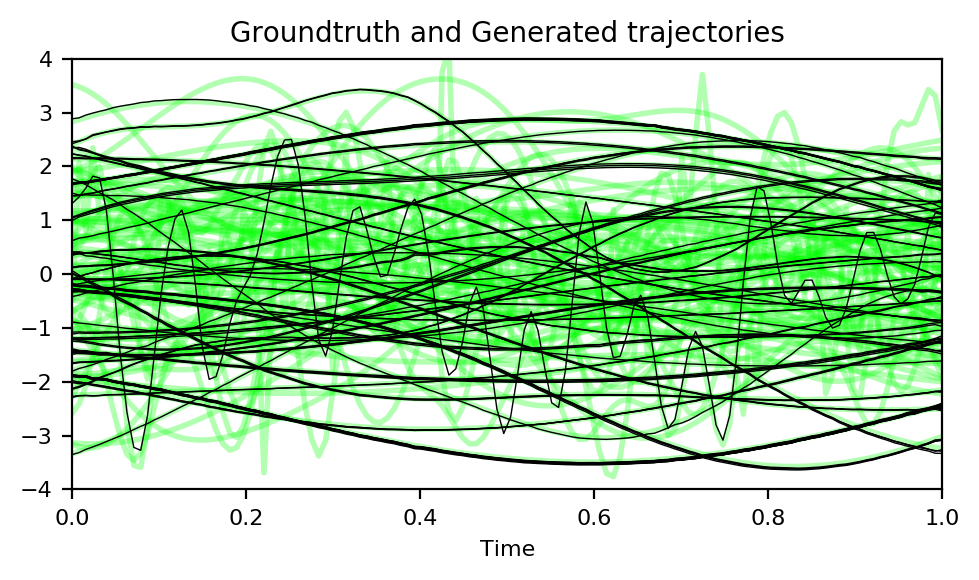

hyp_len:[8.000e-01]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


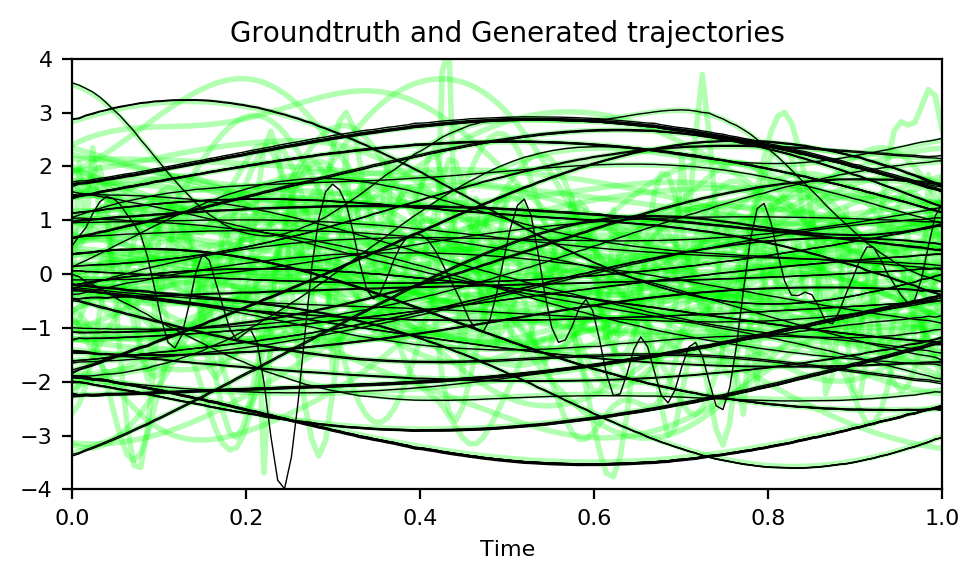

hyp_len:[1.000e+00]
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval
eval


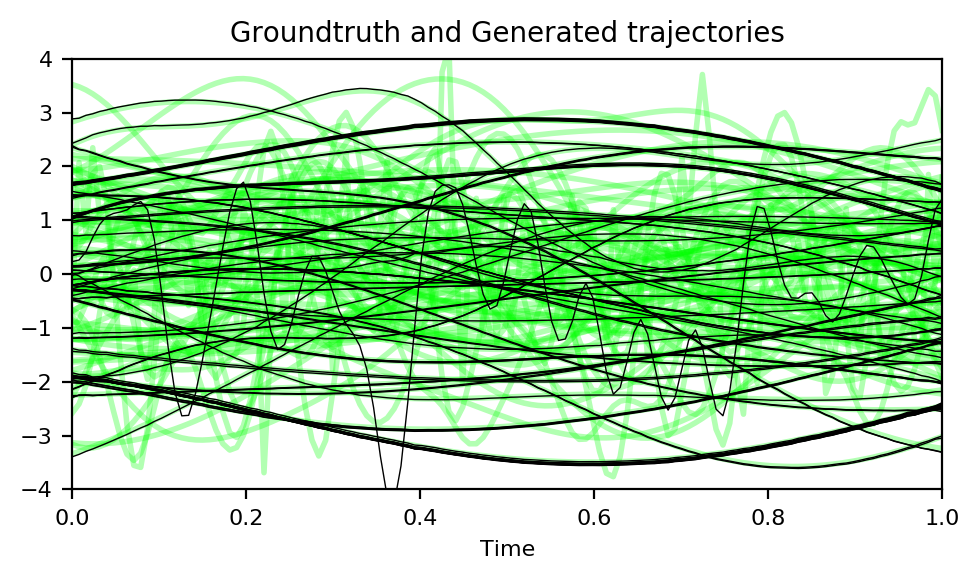

In [34]:
for hyp_len in [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    print ("hyp_len:[%.3e]"%(hyp_len))
    n_sample = 100
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    M_eval = get_hbm_M(times,hyp_gain=1.0,hyp_len=hyp_len,device=device)
    x_t_list = eval_ddpm_1d(
        model,dc,n_sample,x_0,step_list_to_append,device,None, M_eval, th.Tensor([hyp_len]*100).to(device).reshape(100,1))
    plot_ddpm_1d_result(
        times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
        plot_ancestral_sampling=False,plot_one_sample=False,
        lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
        ls_gt='-',ls_sample='-',ylim=(-4,+4),figsize=(5,3))

In [34]:
th.Tensor([hyp_len]*100).to(device).reshape(100,1)

torch.Size([100])

In [31]:
th.Tensor(1)

tensor([9.646e-29])